# North Atlantic Right Whale detector - part 2

This is the second of a two-parts tutorial illustrating how to build a deep learning acoustic detector with Ketos.

We will be using the deep learning classifier that we trained in [Part 1](https://docs.meridian.cs.dal.ca/ketos/tutorials/train_a_narw_classifier/index.html) of this tutorial. As you may recall, this classifier was trained to determine whether a given 3-second audio clip contains a North Atlantic right whale (NARW) upcall. Our goal is now to transform this classifier into a detector that can analyze an audio file (.wav) of an arbitrary duration (e.g. 30 min) and tell us where within that file upcalls occur.

Intuitively, the solution to this problem is straightforward: Simply slide a 3-s wide window across the audio file and use the classifier to determine if an upcall is present within the window at any given instant. However, as you try to implement this solution, you immediately run into a number of practical questions. For example, how large steps should we take when sliding the window?

In this tutorial, we will outline a few different strategies to implemeting the sliding-window approach. Ultimately, however, there is no best strategy, and the preferred strategy will depend on the objectives of your study, e.g., do you need to know the precise location of every upcall, or do you only need to know the call rate per hour, etc.



## Contents:

[1. Importing the packages](#section1)  
[2. Loading the classifier](#section2)  
[3. Inspecting the test data](#section3)  
[4. Choosing a step size](#section4)  
[5. Loading the test data, frame by frame](#section5)  
[6. Feeding the frames to the classifier](#section6)  
[7. Putting it all together - the *process* method](#section7)  
[8. Performance metrics](#section8)  
[9. Notes on execution time](#section9)   
[10. Conclusion](#section10)

<a id=section1></a>

## 1. Importing the packages
We start by importing the modules we will use throughout the tutorial.

In [62]:
import os
import pandas as pd
import ketos.neural_networks.dev_utils.detection as det
from ketos.audio.spectrogram import MagSpectrogram
from ketos.audio.audio_loader import AudioFrameLoader
from ketos.neural_networks.resnet import ResNetInterface
from ketos.neural_networks.dev_utils.detection import process, save_detections
import matplotlib.pyplot as plt
from ketos.neural_networks.dev_utils.export import export_to_ketos_protobuf
%matplotlib inline



<a id=section2></a>

## 2. Loading the classifier

Next, we load the deep learning classifier that we trained in [Part 1](https://docs.meridian.cs.dal.ca/ketos/tutorials/train_a_narw_classifier/index.html) of this tutorial along with the spectrogram parameters used in the training phase. It is important that we use precisely the same set of parameters for computing the spectrograms now, in the inference phase. Otherwise the classifier will get confused!

We load the trained classifier and the spectrogram parameters using the `ResNetInterface.load` method, as follows

In [63]:
#model, audio_repr = ResNetInterface.load(model_file='narw.kt', new_model_folder='./narw_tmp_folder', load_audio_repr=True)
os.chdir('C:\\Users\\kaitlin.palmer\Desktop\\KetosMinke\\Training Data\\CompletedModels\\20230524_01')
model, audio_repr = ResNetInterface.load(model_file="bluewhaleA.kt", load_audio_repr=True,
                                         new_model_folder='./narw_tmp_folder',)

The first argument, `model_file`, specifies the path to the saved classifier; the second argument, `new_model_folder`, is a folder where temporary files needed by the classifier will be saved during execution of the code; finally, with the third argument, `load_audio_repr`, we specify that we want to load not only the classifier, but also the spectrogram parameters.

Let us briefly inspect the spectrogram parameters,

In [25]:
spec_config = audio_repr[0]['spectrogram']
spec_config

{'rate': 500,
 'window': 1.02,
 'step': 0.052,
 'freq_min': 0,
 'freq_max': 250,
 'window_func': 'hamming',
 'type': ketos.audio.spectrogram.MagSpectrogram,
 'duration': 10}

This tells us the type of the spectrogram (Magnitude Spectrogram), the sampling rate of the audio signal (1000 samples/s), the window size (0.256 s), the step size (0.032 s), the minimum and maximum frequencies (0 and 500 Hz), the window function (Hamming), and the duration of each clip (3.0 s).

<a id=section3></a>

## 3. Inspecting the test data

This tutorial includes three audio files, which were recorded in the Gulf of St. Lawrence in the summer of 2016. The files, which are named `sample_1.wav`, `sample_2.wav`, and `sample_3.wav`, contain a total of 26 NARW upcalls. Each file is 30 minute long. We will be using these data to test the performance of our detector.

The time of occurrence of the upcalls is listed in the file `annotations.csv`. Let's take a look at them,

In [ ]:
annot = pd.read_csv('annotations.csv', sep=';')
print(annot)

We see that the file contains two columns, one for the filename, and one for the time of occurrence of the upcall, measured in seconds from the beginning of the file. This time corresponds roughly to the mid point of the upcall.

We can visualize the temporal distribution of the upcalls, like this, using methods from the `matplotlib` package,

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15,3), sharey=True)

for i in range(3):
    filename = f'sample_{i+1}.wav' #filename
    values = annot[annot['sound_file']==filename]['call_time'].values / 60  #select the occurrence times for this file, and convert from seconds to minutes
    axes[i].hist(values, bins=30, range=(0,30)) #plot the data in a histogram
    axes[i].set_xlabel('Time (minutes)') #set axes labels and title
    if i==0: axes[i].set_ylabel('Upcalls per minute')
    axes[i].set_title(filename)

We see that all three files contain upcalls. Moreover, we note that the upcalls have a tendency to cluster.

To inspect the spectrogram representation of individual upcalls, we can use the `MagSpectrogram.from_wav` method of the `ketos` package, like this

In [ ]:
# compute the spectrogram of the 1st upcall, using the spectrogram parameters loaded from the saved model
spec = MagSpectrogram.from_wav(path='audio/sample_1.wav', 
                               offset=1128.840 - 0.5*spec_config['duration'],
                               **spec_config)

spec.plot() #create the figure
plt.show()  #display it!

<a id=section4></a>

## 4. Choosing a step size

The firs step in creating the detector is choosing a suitable step size. Our window is 3 seconds wide, so our step size should certainly not be greater than 3 seconds. Otherwise, we will miss parts of the data. If we make the step size smaller than 3 seconds, consecutive windows will overlap. The smaller the step size, the greater the overlap. 

It is usually desirable to have some overlap between consecutive windows to ensure that all signals are fully captured in at least one window. However, the step size should not be made unnecessarily small as this will increase the computational cost (since more spectrograms will have to be computed and examined by the classifier) without further gain in performance.

For the NARW upcall, which has a duration ranging from 1.0 to 1.5 seconds or so, an overlap of 1.5 seconds would appear to provide the optimal choice if we want to maximize the chances of detecting all the upcalls while not incurring any unnecessary computional costs.

<a id=section5></a>

## 5. Loading the test data, frame by frame

Ketos provides a handy class called `AudioFrameLoader` that helps us split the audio files into (overlapping) frames of equal length and load them one at the time. Moreover, this class can also convert the waveform into a spectrogram representation for us.

To initialize an instance of the AudioFrameLoader, we have to specify the path to the folder where the audio files are stored (`path`), the step size in seconds (`step`), and the spectrogram representation we want as output (`repres`). Thus,

In [30]:
audio_loader = AudioFrameLoader(path='E:\\RECORDINGS\\500Hz\\DRIFT_8_500Hz', duration=spec_config['duration'], 
                                step=3, stop=False, representation=spec_config['type'], representation_params=spec_config)

The `AudioFrameLoader` class as an iterator protocol implemented to load the frames, one by one. It works like this,

In [31]:
first_spec = next(audio_loader) #load the first 3.0-s frame
second_spec = next(audio_loader) #load the second 3.0-s frame
# etc.

Let's take a quick peak at the two spectrograms we have just loaded,

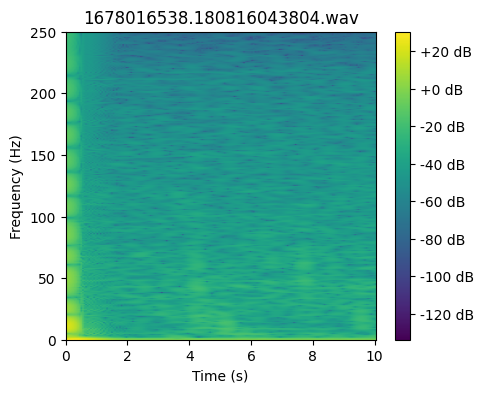

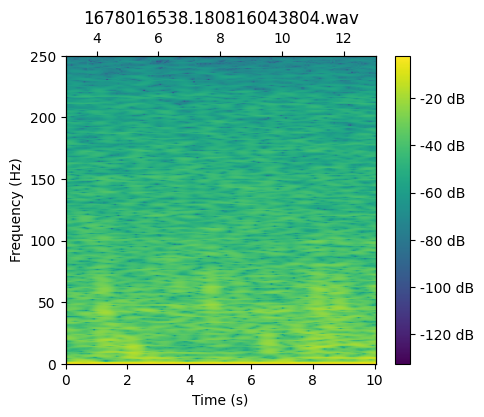

In [32]:
first_spec.plot()
second_spec.plot()
plt.show()

We note that the first 1.5 seconds of the second spectrogram are identical to the last 1.5 seconds of the first spectrogram. (This can also be seen from the top time axis of the second spectrogram, which shows the offset relative to the start of the file.)

Using the `next()` method repeatedly, we can scan through the entire audio recordings. In order to know when to stop, we can use the `num()` method to determine how many frames there are in total,

In [ ]:
print(audio_loader.num())

Another useful method is `reset()`, which resets the audio loader to the first frame. 

In [ ]:
audio_loader.reset()

<a id=section6></a>

## 6. Feeding the frames to the classifier

Now that we know how to load the frames, the next step is to feed them to the classifier. We can feed the frames one at the time using the `run_on_instance` method, like this

In [ ]:
spec = next(audio_loader) #load a spectrogram
data = spec.get_data()    #extract the pixel values as a 2d array
output = model.run_on_instance(data) #pass the pixel values to the classifier
print(output) #print the classifier's output

Let's take a moment to inspect the output returned by the classifier. We see that the classifier has returned a tuple with two elements, `array([0])` and `array([0.64735734])`; these are both arrays with length 1 and 32 floating point precision. 

The first element, `array([0])`, tells us the label predicted by the classifier, in this case a 0, i.e., no upcall. The second element, `array([0.64735734])`, is the ``score`` assigned to the prediction. We can think of this as a measure of the classifier's confidence in its prediction; the higher the score, the larger the confidence.

We can print the label and the score in a more human-readable style, like this

In [ ]:
label = output[0][0]
score = output[1][0]
print(f'label: {label}')
print(f'score: {score}')

When processing entire audio files, it is usually advantageous to feed multiple frames to the classifier at the time, as this will allow for faster processing. This approach is called batch processing, and can be accomplished using the method `run_on_batch` in place of `run_on_instance`.

<a id=section7></a>

## 7. Putting it all together - the *process* method

We now have all the pieces to build our detector. We know how to load spectrograms frame by frame, we know how to feed them to the classifier, and how to handle the classifiers output. All that remains is to place this inside a for loop and then run through the entire test dataset. In fact, Ketos has a method called `process` that does precisely this for us. Let's try it out! (Note: this will take a few moments)

If the atribute `stop` has defined as `True` (defualt), we would have to reset the audio loader before `process`.

In [33]:
# audio_loader.reset() #reset the audio loader before processing
detections = process(audio_loader, model=model, batch_size=64, progress_bar=True)

  2%|▏         | 30/1962 [00:27<31:27,  1.02it/s]RuntimeWarning: Waveform padded with its own reflection to achieve required length to compute the stft. 0 samples were padded on the left and 1004 samples were padded on the right


 14%|█▍        | 280/1962 [04:48<24:01,  1.17it/s]RuntimeWarning: Waveform padded with its own reflection to achieve required length to compute the stft. 0 samples were padded on the left and 1201 samples were padded on the right


 58%|█████▊    | 1129/1962 [18:31<13:09,  1.06it/s]RuntimeWarning: Waveform padded with its own reflection to achieve required length to compute the stft. 0 samples were padded on the left and 1285 samples were padded on the right


100%|██████████| 1962/1962 [31:59<00:00,  1.02it/s]


The `process` method return a list of detections of the form `(filename, offset, duration, score)`. For example, the first detection looks like this,

In [38]:
print(detections[450:455])

[('1678016538.180828051804.wav', 57.0, 10.036, 0.73173743), ('1678016538.180828051804.wav', 69.0, 10.036, 0.592628), ('1678016538.180828051804.wav', 87.0, 10.036, 0.7377758), ('1678016538.180828051804.wav', 90.0, 10.036, 0.9238426), ('1678016538.180828051804.wav', 93.0, 10.036, 0.7541353)]


Next, let us see how many upcalls our detector found,

In [39]:
print(len(detections))

748


This is a great deal higher than the 26 upcalls we expected to find! Of course, since we have 50% overlap between consecutive frames, it is possible that the same upcall is detected two or even three times. Let's check if this is the case by printing the first few detections,

In [40]:
for d in detections[:6]:
    print(d)

('1678016538.180818031804.wav', 57.0, 10.036, 0.67110497)
('1678016538.180818031804.wav', 60.0, 10.036, 0.5005269)
('1678016538.180818031804.wav', 63.0, 10.036, 0.5193339)
('1678016538.180818031804.wav', 66.0, 10.036, 0.7423129)
('1678016538.180818031804.wav', 69.0, 10.036, 0.71037585)
('1678016538.180818035804.wav', 63.0, 10.036, 0.7814353)


We see that the first two detections (at 4.5 s and 6.0 s) are in fact from adjacent frames with 50% overlap. To avoid double counting such detections, we can run the `process` method with the `group` argument set to `True`. The effect of this is to *group* adjacent detections into a single detection with the combined duration.

In [41]:
detections_grp = process(audio_loader, model=model, batch_size=64, progress_bar=True, group=True)

 17%|█▋        | 340/1962 [05:20<25:31,  1.06it/s]


ValueError: 'det_end' cannot be lower than 'det_start'

This greatly reduces the number of detections, but still leaves us with many more detections than there should be.

In [ ]:
print(len(detections_grp))

The `process` method offers two other options for adjusting the sensitivity of the detector. One way to do this is to increase the value of the `threshold` argument, which you may think of as a detection threshold. The value should be between 0 and 1, and as default has the value 0.5. If we lower the threshold, our detector becomes more sensitive; if we increase the threshold, it becomes less sensitive. Let's try a value of 0.7,

In [ ]:
detections_grp_t07 = process(audio_loader, model=model, batch_size=64, progress_bar=True, group=True, threshold=0.7)

In [ ]:
print(len(detections_grp_t07))

Now, we only have 32 detections. That's much better!

Another method to reduce the sensitivity of the detector is apply a running average to the detection scores. This is done with the `win_len` argument, which specifies the length of the averaging window.  Since the running average is applied *before* the threshold, we will likely need to lower the threshold, because the detection scores will dilluted by the surrounding frames. This is a more conservative approach that is less prone to false positives. Let's try with a window size of 5 frames and a threshold of 0.55.

In [ ]:
detections_grp_t055_avg = process(audio_loader, model=model, batch_size=64, progress_bar=True, group=True, threshold=0.55, win_len=5)

In [ ]:
print(len(detections_grp_t055_avg))

This results in the same number of detections, but if we look at them we will notice they are not exactly the same


In [ ]:
detections_grp_t055_avg

In [ ]:
detections_grp_t07

Let us stick with the `detections_grp_t07` (without averaging) for now. Later we'll revisit and compare a few options. 

We can visualize the temporal distribution of the detections in a similar manner to what we did with the annotated upcalls in Section 3.

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15,3), sharey=True)

for i in range(3):
    filename = f'sample_{i+1}.wav' #filename
    values = [(d[1]+0.5*d[2])/60. for d in detections_grp_t07 if d[0]==filename]  #mid-point of detection in minutes
    axes[i].hist(values, bins=30, range=(0,30)) #plot the data in a histogram
    axes[i].set_xlabel('Time (minutes)') #set axes labels and title
    if i==0: axes[i].set_ylabel('Upcalls per minute')
    axes[i].set_title(filename)

A quick visual comparison between the temporal distribution of the detections and the annotated upcalls from Section 3, indicates a good match between the two. In the next section, we will demonstrate how to determine the level of agreement in a more quantitative manner. 

We end this section by demonstrating how to save the detections to a *.csv* file,

In [ ]:
save_detections(detections=detections, save_to='detections.csv')

<a id=section8></a>

## 8. Performance metrics

In the following, we will evaluate how good our detector was at finding individual calls. We will consider a call as detected if the time of occurrence (as reported by the human analyst) is within one of the time intervals flagged by the detector.

The most straightforward way to count the number of detected calls (albeit not the most elegant or fastest) is to construct a nested for-loop, like this,

In [ ]:
#Define a function that compares the upcalls found by the model (detections)
#with the upcalls identified by the human expert (annotations).
#The function returns the annotation DataFrame with an extra boolean 
#column indicating if a given annotated upcall was detected by the model.
def compare(annotations, detections):

    detected_list = []

    for idx,row in annotations.iterrows(): #loop over annotations
        filename_annot = row['sound_file']
        time_annot = row['call_time']
        detected = False
        for d in detections: #loop over detections
            filename_det = d[0]
            start_det    = d[1]
            end_det      = start_det + d[2]
            # if the filenames match and the annotated time falls with the start and 
            # end time of the detection interval, consider the call detected
            if filename_annot==filename_det and time_annot >= start_det and time_annot <= end_det:
                detected = True
                break

        detected_list.append(detected)       

    annotations['detected'] = detected_list  #add column to the annotations table
    
    return annotations

#call the function
annot = compare(annot, detections_grp_t07)

print(annot)            

In [ ]:
annot = compare(annot, detections_grp_t055_avg)

print(annot)

We see that many of the detections do indeed match up with annotated upcalls. We can summarize the performance as follows:

The detector found 17 out of 26 upcalls (Recall of 65%) while also generating 32-17=15 false positives.

However, upon a closer inspection, it can be seen that some of the false positives are actually true positives with a slight temporal misalignment between the annotated call time and the detection time interval. If we re-run the `process` method with a buffer of 1.5 s, the metrics improve considerably, 

In [ ]:
detections_grp_t07_buff = process(audio_loader, model=model, batch_size=64, progress_bar=True, group=True, threshold=0.7, buffer=1.5)

In [ ]:
annot = compare(annot, detections_grp_t07_buff)

print(len(detections_grp_t07_buff))
print(annot) 

Now, the model only misses 5 of the annotated calls (Recall of 81%) while generating 32-21=9 false positives (False Positive Rate of 6 per hour).

Would averaging help? Let's check:

In [ ]:
detections_grp_t055_avg_buff = process(audio_loader, model=model, batch_size=64, progress_bar=True, group=True, threshold=0.55, buffer=1.5, win_len=5)
annot = compare(annot, detections_grp_t055_avg_buff)

print(len(detections_grp_t055_avg_buff))
print(annot) 

Only 15 correct detections, so our previous approach (`detections_grp_t07_buff`) still performs better.

Finally, let's see what happens if we increase the step size from 1.5 s to 3.0 s. In this case, there will be no ovelap between consecutive spectrograms, so it runs a little faster but it could result in some upcalls being missed.

In [ ]:
audio_loader = AudioFrameLoader(path='./audio/', step=3.0, duration=spec_config['duration'], 
    stop=False, representation=spec_config['type'], representation_params=spec_config)
detections = process(audio_loader, model=model, batch_size=64, progress_bar=True, group=True, threshold=0.7, buffer=1.5)

In [ ]:
annot = compare(annot, detections)

print(len(detections))
print(annot) 

We see that the processing took about half as long. However, the number of missed upcalls also increased from 5 to 7.

## 9. Conclusion

In this tutorial we used a pre-trained binary classifier that works on short snapshots to detect North Atlantic right whales in longer recordings. We explored several options and observed how the exact same pre-trained neural network can result in very different performances, depending on how we apply it. Although the quality of model is very important, we highlight that it's worth thinking about how the model will be applied to the task at hand and test the alternatives available.

Once you are happy with your model and have chosen the best way to use it for your workflow, chances are that you will benefit from encapsulate it in some sort of application. Alongside this tutorial, we provided a [Command Line Interface](https://docs.meridian.cs.dal.ca/ketos/tutorials/create_a_narw_detector/index.html) that includes all the options we explored here. After going through this tutorial, you'll be familiar with the functions used in the CLI, which can be used as is for this model (or similar snaphot classifiers you train on your own). It also serves as a template not only for command line tools, but more generally as a way of integrating ketos models into your applications. A CLI is great to be used by other programs. For example, if you need to run a detector on large amounts of archived data and you have acess to a cluster, a CLI is the way to go. If instead you want to develop a web-app that allows your collaborators to use your detector, or even a desktop app with a friendly graphical interface, the same components can be used.

In [66]:
#model, audio_repr = ResNetInterface.load_model_file("C:\\Users\\kaitlin.palmer\\Documents\\GitHub\\BlueWhaleAKetosModel\\Code\\BuildTrainingData\\bluewhaleA.kt", path_to_tmp_folder, load_audio_repr=True)
#export_to_ketos_protobuf(model, 'C:\\Users\\kaitlin.palmer\\Documents\\GitHub\\BlueWhaleAKetosModel\\Code\\BuildTrainingData\\bwA_kp.ktpb', audio_repr=audio_repr)

#Or you can save the model as a .ktpb after training (end of the tutorial). The save_model function can directly export the model in ktpb format  
#bluewhale.save_model('bwA_kp.ktpb', audio_repr=your_audio_repr)


model, audio_repr_new = ResNetInterface.load(model_file="bluewhaleA.kt", load_audio_repr=True)

audio_repr_new

#audio_repr
export_to_ketos_protobuf(model, 'bwA_kp.ktpb', audio_repr=audio_repr_new[0])
#bluewhale.save_model('bwA_kp.ktpb', audio_repr=your_audio_repr)
#model.save_model('bwA_kp.ktpb', audio_repr=audio_repr)

Inferred sample duration of 10s
Inferred input shape of (193, 256)


INFO:tensorflow:Assets written to: tmp_export_folder\model\assets
